# How to use Decima

In [3]:
import numpy as np
import pandas as pd
import anndata
import torch
import os, sys

# Import Decima functions
sys.path.append('../src/')

%matplotlib inline

## Important file paths

In [2]:
# Folder
latest_version = '20240823'
save_dir = f"/gstore/data/resbioai/grelu/decima/{latest_version}"

# Data
matrix_file = os.path.join(save_dir, "data.h5ad") # Includes predictions
h5_file = os.path.join(save_dir, "data.h5")

# Model checkpoints
ckpt_dir = os.path.join(save_dir, 'lightning_logs')
ckpts = [
     os.path.join(ckpt_dir, 'kugrjb50/checkpoints/epoch=3-step=2920.ckpt'),
     os.path.join(ckpt_dir, 'i68hdsdk/checkpoints/epoch=2-step=2190.ckpt'),
     os.path.join(ckpt_dir, '0as9e8of/checkpoints/epoch=7-step=5840.ckpt'),
     os.path.join(ckpt_dir, 'i9zsp4nm/checkpoints/epoch=8-step=6570.ckpt'),
    ]

primary_ckpt = ckpts[0]

print(f'Anndata containing data and predictions: {matrix_file}')
print(f'Gene sequences: {h5_file}')
print(f'Primary model checkpoint: {primary_ckpt}')

Anndata containing data and predictions: /gstore/data/resbioai/grelu/decima/20240823/data.h5ad
Gene sequences: /gstore/data/resbioai/grelu/decima/20240823/data.h5
Primary model checkpoint: /gstore/data/resbioai/grelu/decima/20240823/lightning_logs/kugrjb50/checkpoints/epoch=3-step=2920.ckpt


## How to find predictions for a gene of interest

Both the true and predicted log(CPM+1) matrices are saved in `matrix_file`.

In [3]:
ad = anndata.read_h5ad(matrix_file)

In [4]:
ad

AnnData object with n_obs × n_vars = 8856 × 18457
    obs: 'cell_type', 'tissue', 'organ', 'disease', 'study', 'dataset', 'region', 'subregion', 'celltype_coarse', 'n_cells', 'total_counts', 'n_genes', 'size_factor', 'train_pearson', 'val_pearson', 'test_pearson'
    var: 'chrom', 'start', 'end', 'strand', 'gene_type', 'frac_nan', 'mean_counts', 'n_tracks', 'gene_start', 'gene_end', 'gene_length', 'gene_mask_start', 'gene_mask_end', 'frac_N', 'fold', 'dataset', 'gene_id', 'pearson', 'size_factor_pearson'
    uns: 'disease_pairs', 'log1p'
    layers: 'counts', 'norm', 'preds', 'scaled'

In [5]:
ad.obs.head()

,cell_type,tissue,organ,disease,study,dataset,region,subregion,celltype_coarse,n_cells,total_counts,n_genes,size_factor,train_pearson,val_pearson,test_pearson
agg_0,Amygdala excitatory,Amygdala_Amygdala,CNS,healthy,jhpce#tran2021,brain_atlas,Amygdala,Amygdala,NaN,331,15928830.0,17000,41431.465186,0.942474,0.841879,0.865579
agg_1,Amygdala excitatory,Amygdala_Basolateral nuclear group (BLN) - lat...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Basolateral nuclear group (BLN) - lateral nucl...,NaN,11369,295213300.0,18080,40765.341481,0.943247,0.839565,0.860787
agg_2,Amygdala excitatory,Amygdala_Bed nucleus of stria terminalis and n...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Bed nucleus of stria terminalis and nearby - BNST,NaN,139,2593231.0,15418,42556.387020,0.952271,0.855175,0.866643
agg_3,Amygdala excitatory,Amygdala_Central nuclear group - CEN,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Central nuclear group - CEN,NaN,3892,99463712.0,17959,42884.641430,0.959857,0.863817,0.881534
agg_4,Amygdala excitatory,Amygdala_Corticomedial nuclear group (CMN) - a...,CNS,healthy,SCR_016152,brain_atlas,Amygdala,Corticomedial nuclear group (CMN) - anterior c...,NaN,2945,128161939.0,17885,41816.741933,0.951541,0.855172,0.868277


In [6]:
ad.var.head()

,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,gene_end,gene_length,gene_mask_start,gene_mask_end,frac_N,fold,dataset,gene_id,pearson,size_factor_pearson
STRADA,chr17,63381538,63905826,-,protein_coding,0.000000,2.208074,7616,63682336,63741986,59650,163840,223490,0.0,['fold1'],train,ENSG00000266173,0.492455,0.476627
ETV4,chr17,43219172,43743460,-,protein_coding,0.030873,0.925863,5004,43527844,43579620,51776,163840,215616,0.0,['fold1'],train,ENSG00000175832,0.737548,0.613281
USP25,chr21,15566185,16090473,+,protein_coding,0.000000,3.650355,8604,15730025,15880069,150044,163840,313884,0.0,['fold6'],train,ENSG00000155313,0.905298,0.784446
ZSWIM5,chr1,44945761,45470049,-,protein_coding,0.000620,2.190115,6123,45016399,45306209,289810,163840,453650,0.0,['fold5'],train,ENSG00000162415,0.961775,0.795131
C21orf58,chr21,45963427,46487715,-,protein_coding,0.000791,1.650467,7354,46300181,46323875,23694,163840,187534,0.0,['fold6'],train,ENSG00000160298,0.645260,0.412368


In [7]:
ad.X[:5, :5]

array([[0.52506679, 1.76370326, 5.79917159, 4.78301879, 2.09112987],
       [4.07175813, 1.54301945, 5.70829132, 4.79943454, 1.53793855],
       [4.13834698, 1.58025486, 5.33976252, 5.07680238, 1.58025486],
       [4.02795081, 1.63160098, 5.53684653, 4.84446985, 1.5707875 ],
       [4.05569225, 1.04978108, 5.65868493, 4.99066382, 1.53048553]])

In [8]:
ad.layers['preds'][:5, :5]

array([[3.0019245, 1.7627305, 4.5927725, 5.0999455, 1.7748047],
       [3.0033526, 1.7826542, 4.7232265, 5.5104795, 1.6668196],
       [2.9788709, 2.0896676, 4.8655367, 5.617505 , 1.7732594],
       [3.074754 , 2.0385346, 4.884157 , 5.273578 , 1.7600096],
       [3.1038399, 1.9592154, 4.5908647, 5.2569623, 1.7552438]],
      dtype=float32)

To find true values and predictions for a specific gene (SPI1):

In [9]:
ad.var.loc[['SPI1']]

,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,gene_end,gene_length,gene_mask_start,gene_mask_end,frac_N,fold,dataset,gene_id,pearson,size_factor_pearson
SPI1,chr11,47018128,47542416,-,protein_coding,0.000128,2.187062,7290,47354860,47378576,23716,163840,187556,0.0,['fold3'],test,ENSG00000066336,0.846099,-0.15956


In [10]:
np.array(ad[:, 'SPI1'].X).squeeze()

array([0.75613442, 0.46761271, 1.0743526 , ..., 1.50592079, 0.        ,
       0.48083117])

In [11]:
np.array(ad[:, 'SPI1'].layers['preds']).squeeze()

array([0.2351853 , 0.20646904, 0.15287355, ..., 0.33639783, 0.1378721 ,
       0.20061433], dtype=float32)

## How to visualize the model's predictions for a gene of interest

In [4]:
from decima.visualize import plot_gene_scatter, plot_marker_box

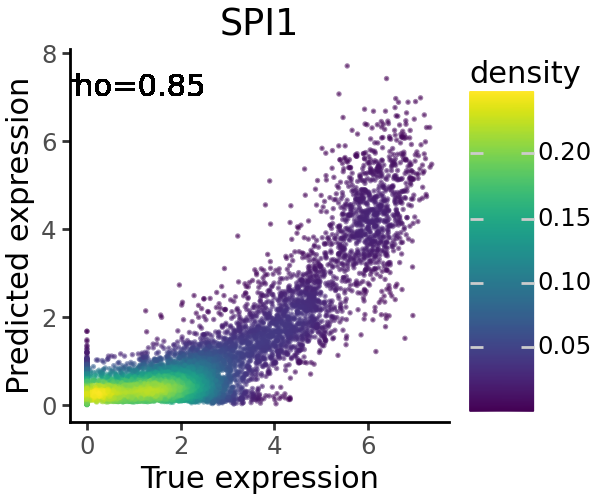

In [13]:
plot_gene_scatter(gene="SPI1", ad=ad)

We can also compare the predictions in specific cell types vs. others:

In [14]:
spi1_cell_types = ['classical monocyte', 'intermediate monocyte', 'non-classical monocyte', 
                 'alveolar macrophage', 'macrophage']

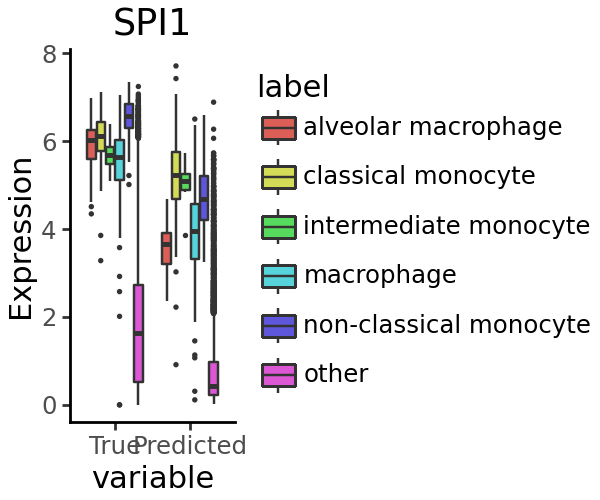

In [15]:
marker_features = {'cell_type': spi1_cell_types}
plot_marker_box(gene='SPI1', ad=ad, marker_features=marker_features)

## How to load the model 

In [16]:
from decima.lightning import LightningModel

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [17]:
model = LightningModel.load_from_checkpoint(primary_ckpt)
model = model.eval()

wandb: Downloading large artifact human_state_dict_fold0:latest, 709.30MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:1.0


## How to get the sequence input for the gene of interest 

The sequence input for each gene is stored in `h5_file`.

In [18]:
from decima.read_hdf5 import extract_gene_data

In [19]:
spi1_input = extract_gene_data(h5_file, "SPI1")

In [20]:
spi1_input.shape

torch.Size([5, 524288])

In [21]:
spi1_input[:, :10]

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

This input corresponds to the sequence between the start and end of SPI1 in `ad.var`, shown below. Note that for negative strand genes such as SPI1, the input is the reverse complemented sequence.
The first 4 channels contain the one-hot encoded sequence. The 5th channel is the 'gene mask' that indicates the boundaries of the gene. It is 0 for positions outside the gene and 1 for positions inside. `gene_mask_start` and `gene_mask_end` contain the positions of the gene boundaries on the input.

In [22]:
ad.var.loc[['SPI1']]

,chrom,start,end,strand,gene_type,frac_nan,mean_counts,n_tracks,gene_start,gene_end,gene_length,gene_mask_start,gene_mask_end,frac_N,fold,dataset,gene_id,pearson,size_factor_pearson
SPI1,chr11,47018128,47542416,-,protein_coding,0.000128,2.187062,7290,47354860,47378576,23716,163840,187556,0.0,['fold3'],test,ENSG00000066336,0.846099,-0.15956


We can check that both the sequence and the gene mask are correct:

In [23]:
from grelu.sequence.format import convert_input_type

In [24]:
torch.all(spi1_input[:4] == convert_input_type(ad.var.loc[['SPI1']], "one_hot", genome="hg38")[0])

tensor(True)

In [25]:
np.where(spi1_input[4] == 1)

(array([163840, 163841, 163842, ..., 187553, 187554, 187555]),)

## How to interpret the model's predictions

To interpret the model's predictions with respect to cell type specificity, we define a set of 'on_tasks' and 'off_tasks' (background tasks).

In [57]:
on_tasks = ad.obs.index[ad.obs.cell_type.isin(spi1_cell_types)].tolist()
off_tasks = ad.obs.index[(~ad.obs.cell_type.isin(spi1_cell_types)) & (ad.obs.organ=="blood")].tolist()

len(on_tasks), len(off_tasks)

(640, 750)

In [27]:
import decima.interpret
from decima.interpret import attributions, find_attr_peaks

seq, tss_pos, attr =  decima.interpret.attributions(
    gene="SPI1", h5_file=h5_file, model=model, device=0, 
    tasks=on_tasks,
    off_tasks=off_tasks,
    transform="specificity")

/usr/local/lib/python3.11/dist-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.


Note that if we only want to interpret the model's predictions for some set of tasks without caring about specificity, we should use `transform="aggregate" and not define `off_tasks`.

In [28]:
attr.shape

(4, 524288)

In addition to the attributions, this function also returns the position of the TSS on the input. This is normally 163840 but this is not the case for all genes.

In [29]:
tss_pos

163840

First, we can visualize the importance across the entire 500 kb interval:

In [30]:
from decima.visualize import plot_attribution_peaks

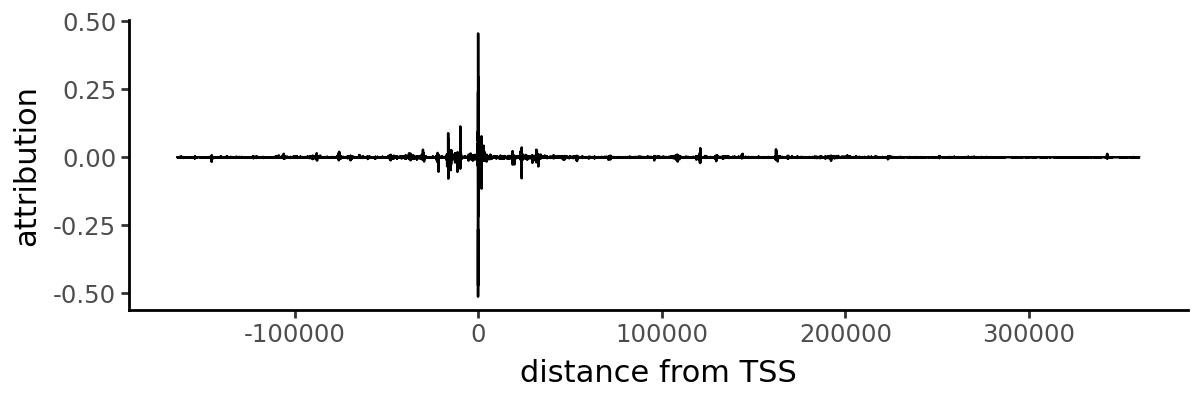

In [31]:
plot_attribution_peaks(attr, tss_pos)

We can also identify the peaks or regions of high importance:

In [32]:
peaks = find_attr_peaks(attr, tss_pos=tss_pos, n=10, min_dist=6)
peaks

,peak,height,from_tss
0,163795,1.822965,-45
1,163878,1.187032,38
2,163771,0.964868,-69
3,163785,0.885268,-55
4,163810,0.800166,-30
5,163886,0.722988,46
6,163870,0.691092,30
7,163898,0.611349,58
8,163849,0.599709,9
9,164109,0.594931,269


We will visualize the attributions close to the TSS (which contains the top two peaks:

In [33]:
from grelu.visualize import plot_attributions

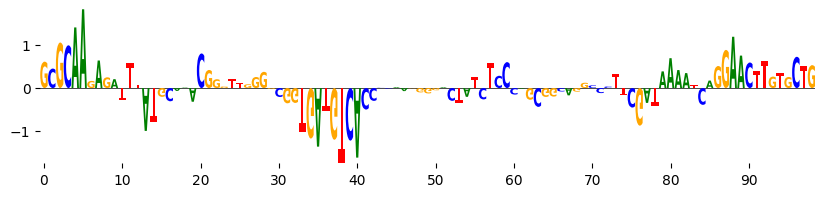

In [34]:
plot_attributions(attr[:, tss_pos-50:tss_pos+50], figsize=(10, 2))

We can also match these top 2 peaks to motifs:

In [35]:
from decima.interpret import motifs_to_df, scan_attributions

In [36]:
motifs = motifs_to_df('jaspar')

Read 1956 motifs from file.


In [37]:
results = scan_attributions(attr, motifs, peaks.iloc[:2], window=18)
results.sort_values('score', ascending=False).groupby('peak').head(3).sort_values('height', ascending=False)

,peak,motif,strand,score,height,from_tss
3163,163795,CEBPB,-,7.270846,1.822965,-45
3267,163795,CEBPE,-,7.237131,1.822965,-45
1163,163795,CEBPG,-,6.641545,1.822965,-45
6617,163878,Spi1,-,4.874591,1.187032,38
6165,163878,SPIB,-,4.614371,1.187032,38
4415,163878,SPIC,-,4.396080,1.187032,38


## How to predict variant impact

To predict variant impact, Decima requires a dataframe containing variant columns (chrom, pos, ref, alt), as well as the gene name. Optionally, the cell type of interest can also be included.

We will use a few fine-mapped eQTLs in this example.

In [38]:
from decima.resources.eqtl import load_susie, filter_susie

In [39]:
variant_df = load_susie(susie_dir='/gstore/data/resbioai/grelu/decima/onek1k/susie/QTS000038')
variant_df = filter_susie(variant_df, ad)

/code/decima/tutorials/../src/decima/resources/eqtl.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Initial number of variants: 874936
Final number of variants: 667625
Keeping 667625 intervals
Keeping 653450 intervals


In [40]:
variant_df = variant_df.head()
variant_df

,chrom,pos,ref,alt,cell_type,gene,gene_id,rsid,region,pip,pvalue,beta
0,chr1,1000018,G,A,"CD8-positive, alpha-beta T cell",ISG15,ENSG00000187608,rs146254088,chr1:1138-2001138,0.117562,4.389340e-07,-0.725016
1,chr1,1002308,T,C,"CD8-positive, alpha-beta T cell",ISG15,ENSG00000187608,rs2489000,chr1:1138-2001138,0.048946,1.113460e-06,0.651041
2,chr1,109727471,A,C,"CD8-positive, alpha-beta T cell",GSTM3,ENSG00000134202,rs11101994,chr1:108741038-110741038,0.186748,7.235260e-32,0.490154
3,chr1,109728286,T,G,"CD8-positive, alpha-beta T cell",GSTM3,ENSG00000134202,rs4540683,chr1:108741038-110741038,0.185188,7.290630e-32,0.489905
4,chr1,109728807,T,G,"CD8-positive, alpha-beta T cell",GSTM3,ENSG00000134202,rs4970775,chr1:108741038-110741038,0.063999,2.111820e-31,0.488325


We first need to ensure that these variants are close enough to a gene.

In [41]:
from decima.variant import process_variants

In [42]:
variant_df = process_variants(variant_df, ad, min_from_end=5000)
variant_df

dropped 0 variants because the gene was not found in ad.var
dropped 0 variants because the variant did not fit in the interval


,chrom,pos,ref,alt,cell_type,gene,gene_id,rsid,region,pip,pvalue,beta,start,end,strand,gene_mask_start,rel_pos,ref_tx,alt_tx,tss_dist
0,chr1,1000018,G,A,"CD8-positive, alpha-beta T cell",ISG15,ENSG00000187608,rs146254088,chr1:1138-2001138,0.117562,4.389340e-07,-0.725016,837298,1361586,+,163840,162720,G,A,-1120
1,chr1,1002308,T,C,"CD8-positive, alpha-beta T cell",ISG15,ENSG00000187608,rs2489000,chr1:1138-2001138,0.048946,1.113460e-06,0.651041,837298,1361586,+,163840,165010,T,C,1170
2,chr1,109727471,A,C,"CD8-positive, alpha-beta T cell",GSTM3,ENSG00000134202,rs11101994,chr1:108741038-110741038,0.186748,7.235260e-32,0.490154,109380590,109904878,-,163840,177407,T,G,13567
3,chr1,109728286,T,G,"CD8-positive, alpha-beta T cell",GSTM3,ENSG00000134202,rs4540683,chr1:108741038-110741038,0.185188,7.290630e-32,0.489905,109380590,109904878,-,163840,176592,A,C,12752
4,chr1,109728807,T,G,"CD8-positive, alpha-beta T cell",GSTM3,ENSG00000134202,rs4970775,chr1:108741038-110741038,0.063999,2.111820e-31,0.488325,109380590,109904878,-,163840,176071,A,C,12231


Now we can create the reference and alternate allele containing inputs:

In [43]:
from decima.read_hdf5 import VariantDataset

In [44]:
dataset = VariantDataset(variant_df, h5_file)

In [45]:
ref = dataset[0]
alt = dataset[1]

In [46]:
ref.shape, alt.shape

(torch.Size([5, 524288]), torch.Size([5, 524288]))

In [47]:
np.where(ref!=alt)

(array([0, 2]), array([162720, 162720]))

In [48]:
1000018-837298

162720

Also, suppose we only want to make predictions in selected cell types, we can subset those tracks using the `Aggregate` transform.

In [49]:
relevant_tasks = ad.obs.index[(ad.obs.tissue=="blood") & (ad.obs.disease.isin(["healthy", "NA"])) & (ad.obs.cell_type.isin(variant_df.cell_type))].tolist()
len(relevant_tasks)

38

In [50]:
from grelu.transforms.prediction_transforms import Aggregate

In [51]:
agg_transform = Aggregate(tasks=relevant_tasks, model=model)
model.add_transform(agg_transform)

Now we can compute variant effects:

In [52]:
preds = model.predict_on_dataset(dataset, devices=1, batch_size=8, num_workers=16)
preds = anndata.AnnData(X=preds, obs=variant_df.set_index('rsid'), var=ad.obs.loc[relevant_tasks])
preds.shape

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.59it/s]


(5, 38)

In [53]:
preds

AnnData object with n_obs × n_vars = 5 × 38
    obs: 'chrom', 'pos', 'ref', 'alt', 'cell_type', 'gene', 'gene_id', 'region', 'pip', 'pvalue', 'beta', 'start', 'end', 'strand', 'gene_mask_start', 'rel_pos', 'ref_tx', 'alt_tx', 'tss_dist'
    var: 'cell_type', 'tissue', 'organ', 'disease', 'study', 'dataset', 'region', 'subregion', 'celltype_coarse', 'n_cells', 'total_counts', 'n_genes', 'size_factor', 'train_pearson', 'val_pearson', 'test_pearson'

In [54]:
preds.obs

,chrom,pos,ref,alt,cell_type,gene,gene_id,region,pip,pvalue,beta,start,end,strand,gene_mask_start,rel_pos,ref_tx,alt_tx,tss_dist
rsid,,,,,,,,,,,,,,,,,,,
rs146254088,chr1,1000018,G,A,"CD8-positive, alpha-beta T cell",ISG15,ENSG00000187608,chr1:1138-2001138,0.117562,4.389340e-07,-0.725016,837298,1361586,+,163840,162720,G,A,-1120
rs2489000,chr1,1002308,T,C,"CD8-positive, alpha-beta T cell",ISG15,ENSG00000187608,chr1:1138-2001138,0.048946,1.113460e-06,0.651041,837298,1361586,+,163840,165010,T,C,1170
rs11101994,chr1,109727471,A,C,"CD8-positive, alpha-beta T cell",GSTM3,ENSG00000134202,chr1:108741038-110741038,0.186748,7.235260e-32,0.490154,109380590,109904878,-,163840,177407,T,G,13567
rs4540683,chr1,109728286,T,G,"CD8-positive, alpha-beta T cell",GSTM3,ENSG00000134202,chr1:108741038-110741038,0.185188,7.290630e-32,0.489905,109380590,109904878,-,163840,176592,A,C,12752
rs4970775,chr1,109728807,T,G,"CD8-positive, alpha-beta T cell",GSTM3,ENSG00000134202,chr1:108741038-110741038,0.063999,2.111820e-31,0.488325,109380590,109904878,-,163840,176071,A,C,12231


In [55]:
preds.var.head()

,cell_type,tissue,organ,disease,study,dataset,region,subregion,celltype_coarse,n_cells,total_counts,n_genes,size_factor,train_pearson,val_pearson,test_pearson
agg_843,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE128243,scimilarity,nan,nan,NaN,5597,10483704.0,13250,28325.408660,0.941655,0.808412,0.813604
agg_844,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE132950,scimilarity,nan,nan,NaN,1334,7219685.0,13394,32566.675556,0.964465,0.847792,0.843420
agg_845,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE135325,scimilarity,nan,nan,NaN,261,612912.0,10905,29777.260442,0.936802,0.808541,0.801103
agg_847,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE149356,scimilarity,nan,nan,NaN,2054,7534250.0,13387,33923.162424,0.951058,0.818623,0.830627
agg_849,"CD8-positive, alpha-beta T cell",blood,blood,NA,GSE151310,scimilarity,nan,nan,NaN,12443,29209159.0,13809,29807.259230,0.965129,0.829639,0.820742


In [56]:
preds.X.shape

(5, 38)